# TESLA (TSLA) Trading Signal Features

### Import Libraries and Dependencies

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


import warnings
warnings.filterwarnings('ignore')


Bad key savefig.frameon in file /Users/Lidiya/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/Lidiya/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/Lidiya/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

### Read in CSV as Pandas DataFrame

In [2]:
# Reading CSV file from Github Repo (TSLA_DATE_CLOSE.csv)

url = 'https://raw.githubusercontent.com/klleung72781/fintech_project_2/main/TSLA_DATE_CLOSE.csv'
df = pd.read_csv(url, parse_dates=True, error_bad_lines=False, index_col='Date', infer_datetime_format=True)
df = df.sort_index()
df.head(5)

,Close
Date,
2010-06-29,4.78
2010-06-30,4.77
2010-07-01,4.39
2010-07-02,3.84
2010-07-06,3.22


In [3]:
# Reading CSV file from Github Repo (clean_tweeter.csv)

url_2 = 'https://raw.githubusercontent.com/klleung72781/fintech_project_2/main/clean_twitter.csv'
twitter_df = pd.read_csv(url_2, parse_dates=True, index_col='Date', infer_datetime_format=True)
twitter_df.sort_index()
twitter_df.head(5)

,SENT
Date,
2015-01-30,1.00
2015-02-08,0.25
2015-02-10,0.00
2015-02-11,0.50
2015-02-12,0.00


In [4]:
#Creating a function to replace values in the SENT with (0,1,-1)

def encode(x):
    if x >= -1 and x < -0.5:
        return -1
    elif x >= -0.5 and x < 0.5:
        return 0
    else:
        return 1
twitter_df.SENT = twitter_df.SENT.apply(
    lambda x: encode(x)
)

In [5]:
# Fill out missing dates in twitter_df with adding addition dates and 0 values: 

idx = pd.date_range('01-30-2015', '10-12-2020')


twitter_df.index = pd.DatetimeIndex(twitter_df.index)

twitter_df = twitter_df.reindex(idx, fill_value=0)
twitter_df.head(5)

,SENT
2015-01-30,1
2015-01-31,0
2015-02-01,0
2015-02-02,0
2015-02-03,0


In [6]:
# Drop NAs and calculate daily percent return

df['Daily_return'] = df['Close'].dropna().pct_change()
df.index = pd.DatetimeIndex(df.index)
df.head(5)


,Close,Daily_return
Date,,
2010-06-29,4.78,NaN
2010-06-30,4.77,-0.002092
2010-07-01,4.39,-0.079665
2010-07-02,3.84,-0.125285
2010-07-06,3.22,-0.161458


In [7]:
#Creating DataFrame with returns and Actual Value

daily_df = df.copy().drop(columns=["Close"])
daily_df["Actual_Value"] = np.where(df['Daily_return'] > 0 ,1, 0)
daily_df = daily_df.dropna()
daily_df.head()

,Daily_return,Actual_Value
Date,,
2010-06-30,-0.002092,0
2010-07-01,-0.079665,0
2010-07-02,-0.125285,0
2010-07-06,-0.161458,0
2010-07-07,-0.018634,0


In [8]:
# Set short and long windows

short_window = 50
long_window = 200

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df['fast_close'] = df['Close'].ewm(halflife=short_window).mean()
df['slow_close'] = df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
df['crossover_long'] = np.where(df['fast_close'] > df['slow_close'], 1.0, 0.0)
df['crossover_short'] = np.where(df['fast_close'] < df['slow_close'], -1.0, 0.0)
df['crossover_signal'] = df['crossover_long'] + df['crossover_short']

df.head(5)


,Close,Daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,
2010-06-29,4.78,NaN,4.780000,4.780000,0.0,0.0,0.0
2010-06-30,4.77,-0.002092,4.774965,4.774991,0.0,-1.0,-1.0
2010-07-01,4.39,-0.079665,4.644861,4.646216,0.0,-1.0,-1.0
2010-07-02,3.84,-0.125285,4.439442,4.443613,0.0,-1.0,-1.0
2010-07-06,3.22,-0.161458,4.188745,4.197191,0.0,-1.0,-1.0


<AxesSubplot:xlabel='Date'>

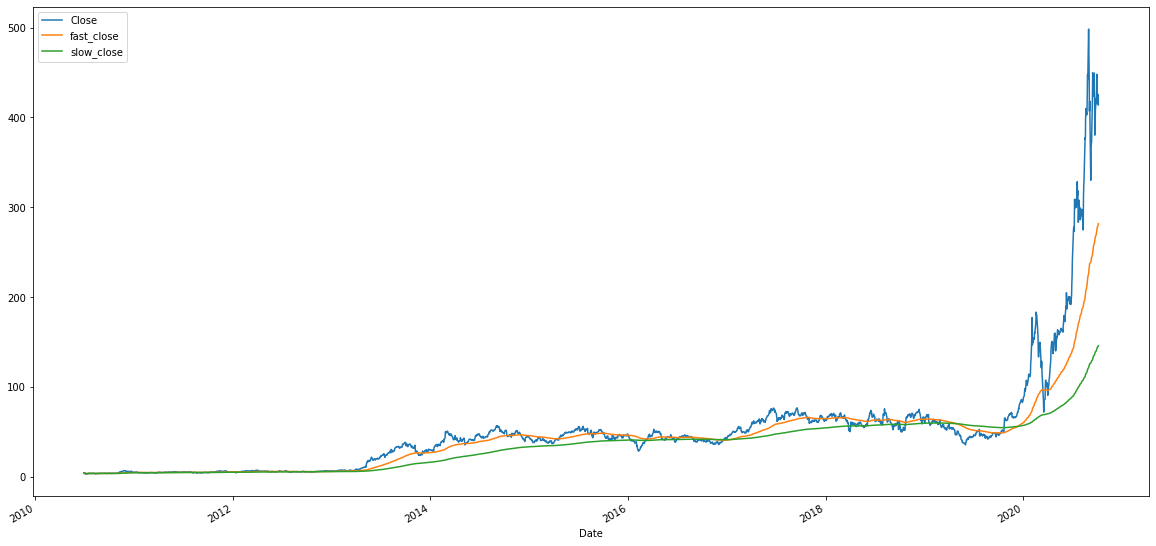

In [9]:
# Plot the EMA of TSLA closing prices

df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [10]:
# Set short and long volatility windows

short_vol_window = 20
long_vol_window = 100

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df['fast_vol'] = df['Daily_return'].ewm(halflife=short_vol_window).std()
df['slow_vol'] = df['Daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
df['vol_trend_long'] = np.where(df['fast_vol'] < df['slow_vol'], 1.0, 0.0)
df['vol_trend_short'] = np.where(df['fast_vol'] > df['slow_vol'], -1.0, 0.0) 
df['vol_trend_signal'] = df['vol_trend_long'] + df['vol_trend_short']

df.head(5)

,Close,Daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,
2010-06-29,4.78,NaN,4.780000,4.780000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2010-06-30,4.77,-0.002092,4.774965,4.774991,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2010-07-01,4.39,-0.079665,4.644861,4.646216,0.0,-1.0,-1.0,0.054852,0.054852,0.0,0.0,0.0
2010-07-02,3.84,-0.125285,4.439442,4.443613,0.0,-1.0,-1.0,0.062094,0.062246,1.0,0.0,1.0
2010-07-06,3.22,-0.161458,4.188745,4.197191,0.0,-1.0,-1.0,0.068328,0.068645,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

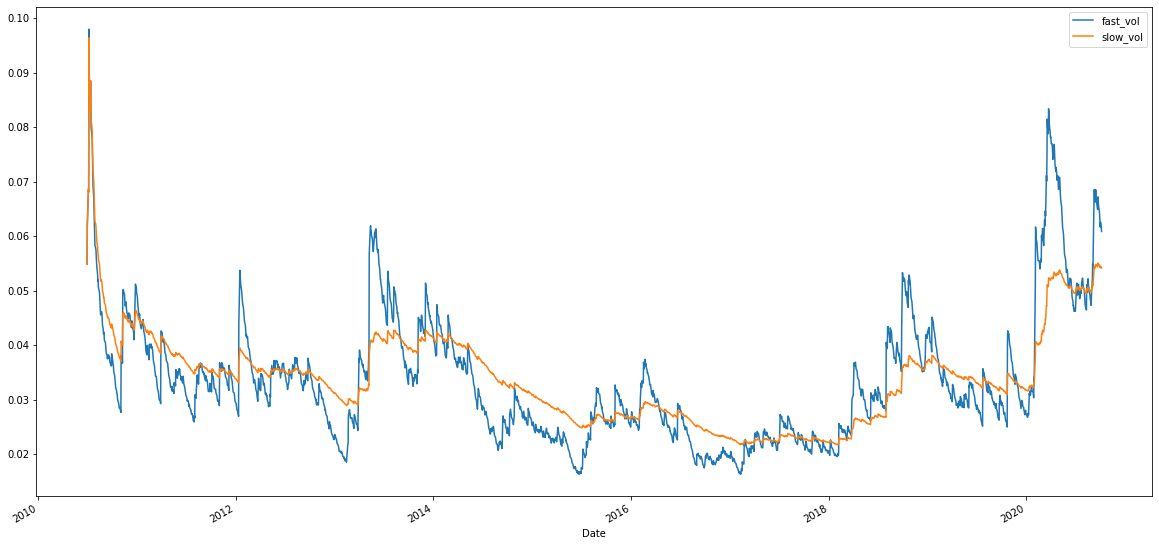

In [11]:
# Plot the EMA of TSLA daily return volatility

df[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [12]:
# Set bollinger band window

bollinger_window = 20

# Calculate rolling mean and standard deviation
df['bollinger_mid_band'] = df['Close'].rolling(window=bollinger_window).mean()
df['bollinger_std'] = df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
df['bollinger_upper_band']  = df['bollinger_mid_band'] + (df['bollinger_std'] * 2)
df['bollinger_lower_band']  = df['bollinger_mid_band'] - (df['bollinger_std'] * 2)

# Calculate bollinger band trading signal
df['bollinger_long'] = np.where(df['Close'] < df['bollinger_lower_band'], 1.0, 0.0)
df['bollinger_short'] = np.where(df['Close'] > df['bollinger_upper_band'], -1.0, 0.0)
df['bollinger_signal'] = df['bollinger_long'] + df['bollinger_short']

df.head(5)

,Close,Daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,
2010-06-29,4.78,NaN,4.780000,4.780000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-06-30,4.77,-0.002092,4.774965,4.774991,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-07-01,4.39,-0.079665,4.644861,4.646216,0.0,-1.0,-1.0,0.054852,0.054852,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-07-02,3.84,-0.125285,4.439442,4.443613,0.0,-1.0,-1.0,0.062094,0.062246,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-07-06,3.22,-0.161458,4.188745,4.197191,0.0,-1.0,-1.0,0.068328,0.068645,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


<AxesSubplot:xlabel='Date'>

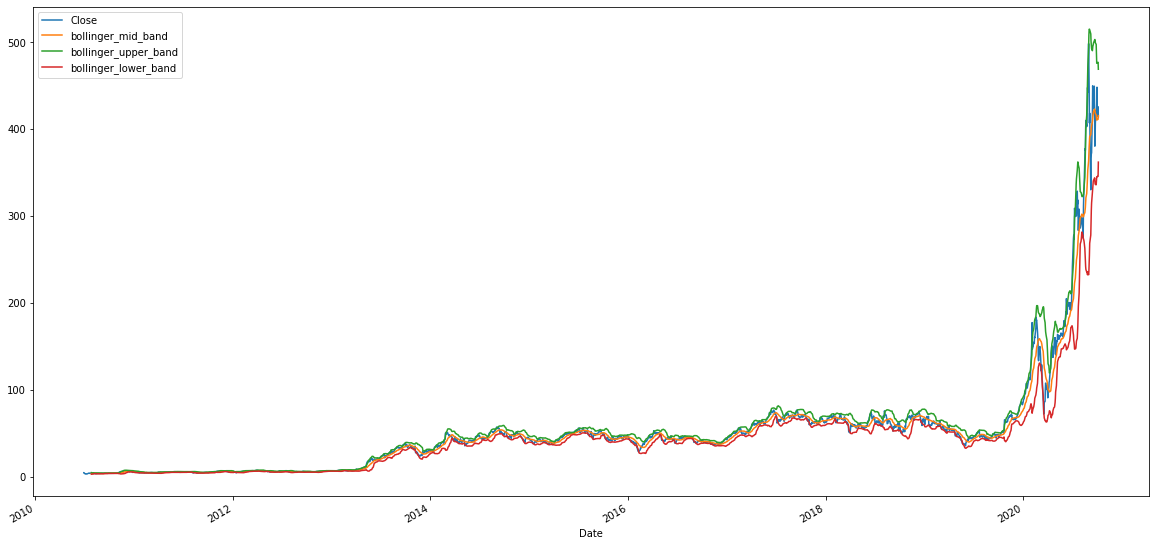

In [13]:
# Plot the Bollinger Bands for TLSA closing prices

df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [14]:
# Renaming df to trading_signals_df

trading_signals_df = df
trading_signals_df = trading_signals_df.dropna()
trading_signals_df.head(5)

,Close,Daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,
2010-07-27,4.11,-0.019093,3.978296,3.975310,1.0,0.0,1.0,0.064452,0.067885,1.0,0.0,1.0,3.9745,0.459925,4.894351,3.054649,0.0,0.0,0.0
2010-07-28,4.14,0.007299,3.987110,3.983427,1.0,0.0,1.0,0.062183,0.066017,1.0,0.0,1.0,3.9425,0.421599,4.785699,3.099301,0.0,0.0,0.0
2010-07-29,4.07,-0.016908,3.991452,3.987507,1.0,0.0,1.0,0.060155,0.064295,1.0,0.0,1.0,3.9075,0.375862,4.659224,3.155776,0.0,0.0,0.0
2010-07-30,3.99,-0.019656,3.991378,3.987619,1.0,0.0,1.0,0.058298,0.062720,1.0,0.0,1.0,3.8875,0.359105,4.605710,3.169290,0.0,0.0,0.0
2010-08-02,4.18,0.047619,4.000554,3.995959,1.0,0.0,1.0,0.057807,0.062239,1.0,0.0,1.0,3.9045,0.364742,4.633984,3.175016,0.0,0.0,0.0


In [15]:
# Concating dataframes to one: 

trading_signals_df = pd.concat([twitter_df, trading_signals_df], axis=1)
trading_signals_df.head(5)

,SENT,Close,Daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
2010-07-27,NaN,4.11,-0.019093,3.978296,3.975310,1.0,0.0,1.0,0.064452,0.067885,1.0,0.0,1.0,3.9745,0.459925,4.894351,3.054649,0.0,0.0,0.0
2010-07-28,NaN,4.14,0.007299,3.987110,3.983427,1.0,0.0,1.0,0.062183,0.066017,1.0,0.0,1.0,3.9425,0.421599,4.785699,3.099301,0.0,0.0,0.0
2010-07-29,NaN,4.07,-0.016908,3.991452,3.987507,1.0,0.0,1.0,0.060155,0.064295,1.0,0.0,1.0,3.9075,0.375862,4.659224,3.155776,0.0,0.0,0.0
2010-07-30,NaN,3.99,-0.019656,3.991378,3.987619,1.0,0.0,1.0,0.058298,0.062720,1.0,0.0,1.0,3.8875,0.359105,4.605710,3.169290,0.0,0.0,0.0
2010-08-02,NaN,4.18,0.047619,4.000554,3.995959,1.0,0.0,1.0,0.057807,0.062239,1.0,0.0,1.0,3.9045,0.364742,4.633984,3.175016,0.0,0.0,0.0


In [16]:
#Dropping NaN values:

trading_signals_df = trading_signals_df.dropna()
trading_signals_df.head(5)

,SENT,Close,Daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
2015-01-30,1.0,40.72,-0.007797,44.802278,34.166278,1.0,0.0,1.0,0.024043,0.029932,1.0,0.0,1.0,40.6505,1.492647,43.635794,37.665206,0.0,0.0,0.0
2015-02-02,0.0,42.19,0.036100,44.766314,34.194551,1.0,0.0,1.0,0.024627,0.029972,1.0,0.0,1.0,40.5670,1.342849,43.252698,37.881302,0.0,0.0,0.0
2015-02-03,0.0,43.67,0.035079,44.751221,34.227937,1.0,0.0,1.0,0.025065,0.030003,1.0,0.0,1.0,40.6495,1.480450,43.610399,37.688601,0.0,-1.0,-1.0
2015-02-04,0.0,43.71,0.000916,44.736886,34.261344,1.0,0.0,1.0,0.024634,0.029899,1.0,0.0,1.0,40.7220,1.594575,43.911150,37.532850,0.0,0.0,0.0
2015-02-05,0.0,44.20,0.011210,44.729495,34.296358,1.0,0.0,1.0,0.024287,0.029807,1.0,0.0,1.0,40.8225,1.747934,44.318367,37.326633,0.0,0.0,0.0


In [17]:
# Set x variable list of features

x_var_list = ['crossover_signal', 'bollinger_signal', 'SENT', 'vol_trend_signal']

# Filter by x-variable list
trading_signals_df[x_var_list]

,crossover_signal,bollinger_signal,SENT,vol_trend_signal
2015-01-30,1.0,0.0,1.0,1.0
2015-02-02,1.0,0.0,0.0,1.0
2015-02-03,1.0,-1.0,0.0,1.0
2015-02-04,1.0,0.0,0.0,1.0
2015-02-05,1.0,0.0,0.0,1.0
...,...,...,...,...
2020-09-30,1.0,0.0,0.0,-1.0
2020-10-01,1.0,0.0,0.0,-1.0
2020-10-02,1.0,0.0,0.0,-1.0
2020-10-05,1.0,0.0,0.0,-1.0


In [18]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list]

,crossover_signal,bollinger_signal,SENT,vol_trend_signal
2015-01-30,NaN,NaN,NaN,NaN
2015-02-02,1.0,0.0,1.0,1.0
2015-02-03,1.0,0.0,0.0,1.0
2015-02-04,1.0,-1.0,0.0,1.0
2015-02-05,1.0,0.0,0.0,1.0
...,...,...,...,...
2020-09-30,1.0,0.0,0.0,-1.0
2020-10-01,1.0,0.0,0.0,-1.0
2020-10-02,1.0,0.0,0.0,-1.0
2020-10-05,1.0,0.0,0.0,-1.0


In [19]:
# Drop NAs and replace positive/negative infinity values

trading_signals_df.dropna(subset=x_var_list, inplace=True)
trading_signals_df.dropna(subset=['Daily_return'], inplace=True)
trading_signals_df= trading_signals_df.replace([np.inf, -np.inf], np.nan)
trading_signals_df.head(5)

,SENT,Close,Daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
2015-02-02,1.0,42.19,0.036100,44.766314,34.194551,1.0,0.0,1.0,0.024627,0.029972,1.0,0.0,1.0,40.5670,1.342849,43.252698,37.881302,0.0,0.0,0.0
2015-02-03,0.0,43.67,0.035079,44.751221,34.227937,1.0,0.0,1.0,0.025065,0.030003,1.0,0.0,1.0,40.6495,1.480450,43.610399,37.688601,0.0,-1.0,0.0
2015-02-04,0.0,43.71,0.000916,44.736886,34.261344,1.0,0.0,1.0,0.024634,0.029899,1.0,0.0,1.0,40.7220,1.594575,43.911150,37.532850,0.0,0.0,-1.0
2015-02-05,0.0,44.20,0.011210,44.729495,34.296358,1.0,0.0,1.0,0.024287,0.029807,1.0,0.0,1.0,40.8225,1.747934,44.318367,37.326633,0.0,0.0,0.0
2015-02-06,0.0,43.47,-0.016516,44.712155,34.328674,1.0,0.0,1.0,0.024086,0.029740,1.0,0.0,1.0,40.8900,1.825042,44.540084,37.239916,0.0,0.0,0.0


In [20]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.

trading_signals_df['Positive Return'] = np.where(trading_signals_df['Daily_return'] > 0, 1.0, 0.0)
trading_signals_df.head(5)

,SENT,Close,Daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
2015-02-02,1.0,42.19,0.036100,44.766314,34.194551,1.0,0.0,1.0,0.024627,0.029972,...,0.0,1.0,40.5670,1.342849,43.252698,37.881302,0.0,0.0,0.0,1.0
2015-02-03,0.0,43.67,0.035079,44.751221,34.227937,1.0,0.0,1.0,0.025065,0.030003,...,0.0,1.0,40.6495,1.480450,43.610399,37.688601,0.0,-1.0,0.0,1.0
2015-02-04,0.0,43.71,0.000916,44.736886,34.261344,1.0,0.0,1.0,0.024634,0.029899,...,0.0,1.0,40.7220,1.594575,43.911150,37.532850,0.0,0.0,-1.0,1.0
2015-02-05,0.0,44.20,0.011210,44.729495,34.296358,1.0,0.0,1.0,0.024287,0.029807,...,0.0,1.0,40.8225,1.747934,44.318367,37.326633,0.0,0.0,0.0,1.0
2015-02-06,0.0,43.47,-0.016516,44.712155,34.328674,1.0,0.0,1.0,0.024086,0.029740,...,0.0,1.0,40.8900,1.825042,44.540084,37.239916,0.0,0.0,0.0,0.0


In [21]:
# Construct training start and end dates

training_start = trading_signals_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2019-10-04'

# Construct testing start and end dates
testing_start =  '2019-10-07'
testing_end = trading_signals_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2015-02-02
Training End: 2019-10-04
Testing Start: 2019-10-07
Testing End: 2020-10-06


In [22]:
# Construct the X_train and y_train datasets

X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df['Positive Return'][training_start:training_end]

X_train.tail(5)

,crossover_signal,bollinger_signal,SENT,vol_trend_signal
2019-09-30,-1.0,0.0,0.0,1.0
2019-10-01,-1.0,0.0,1.0,1.0
2019-10-02,-1.0,0.0,0.0,1.0
2019-10-03,-1.0,0.0,0.0,1.0
2019-10-04,-1.0,0.0,1.0,1.0


In [23]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df['Positive Return'][testing_start:testing_end]

X_test.tail(5)

,crossover_signal,bollinger_signal,SENT,vol_trend_signal
2020-09-30,1.0,0.0,0.0,-1.0
2020-10-01,1.0,0.0,0.0,-1.0
2020-10-02,1.0,0.0,0.0,-1.0
2020-10-05,1.0,0.0,0.0,-1.0
2020-10-06,1.0,0.0,0.0,-1.0


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [25]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train): (n_est = number of tress, depth is depth in each tree)

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results.head(5)

,Positive Return,Predicted Value
2019-10-07,1.0,0.0
2019-10-08,1.0,0.0
2019-10-09,1.0,0.0
2019-10-10,1.0,0.0
2019-10-11,1.0,0.0


In [26]:
pwd

'/Users/Lidiya/Desktop/fintech_project_2'

In [27]:
# Save the pre-trained model

from joblib import dump, load
dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [28]:
# Set index as datetime object and drop extraneous columns

daily_df.set_index(pd.to_datetime(daily_df.index, infer_datetime_format=True), inplace=True)
daily_df.sort_index()
#df.drop(columns=['index'], inplace=True)


daily_df.dropna(inplace=True)
daily_df.head()

,Daily_return,Actual_Value
Date,,
2010-06-30,-0.002092,0
2010-07-01,-0.079665,0
2010-07-02,-0.125285,0
2010-07-06,-0.161458,0
2010-07-07,-0.018634,0


In [29]:
# Taking 253 values from the begining head of the df
daily_df = daily_df.iloc[-253:] 
daily_df.head(5)

,Daily_return,Actual_Value
Date,,
2019-10-07,0.027004,1
2019-10-08,0.009886,1
2019-10-09,0.018746,1
2019-10-10,0.000818,1
2019-10-11,0.012870,1


In [30]:
# Making predictoins on the X_test: 
model = load('random_forest_model.joblib')
predictions = model.predict(X_test)
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 0.

In [31]:
# Add predicted results to DataFrame

daily_df["Predicted_Value"] = predictions
daily_df.head(5)

,Daily_return,Actual_Value,Predicted_Value
Date,,,
2019-10-07,0.027004,1,0.0
2019-10-08,0.009886,1,0.0
2019-10-09,0.018746,1,0.0
2019-10-10,0.000818,1,0.0
2019-10-11,0.012870,1,0.0


<AxesSubplot:xlabel='Date'>

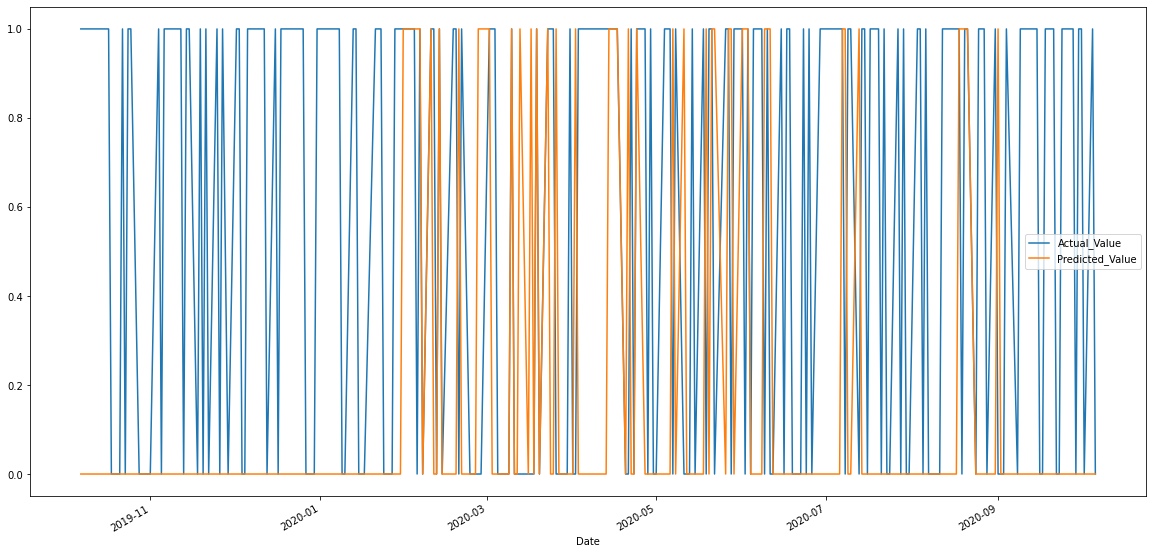

In [32]:
# Plot predicted results vs. actual results

daily_df[['Actual_Value', 'Predicted_Value']].plot(figsize=(20,10))


<AxesSubplot:xlabel='Date'>

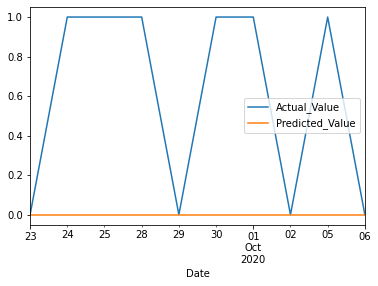

In [33]:
# Plot last 10 records of predicted vs. actual results

daily_df[['Actual_Value', 'Predicted_Value']].tail(10).plot()

In [34]:
# Replace predicted values 0 to -1 to account for shorting

daily_df['Predicted_Value'].replace(0, -1, inplace=True)
daily_df.head()


,Daily_return,Actual_Value,Predicted_Value
Date,,,
2019-10-07,0.027004,1,-1.0
2019-10-08,0.009886,1,-1.0
2019-10-09,0.018746,1,-1.0
2019-10-10,0.000818,1,-1.0
2019-10-11,0.012870,1,-1.0


<AxesSubplot:xlabel='Date'>

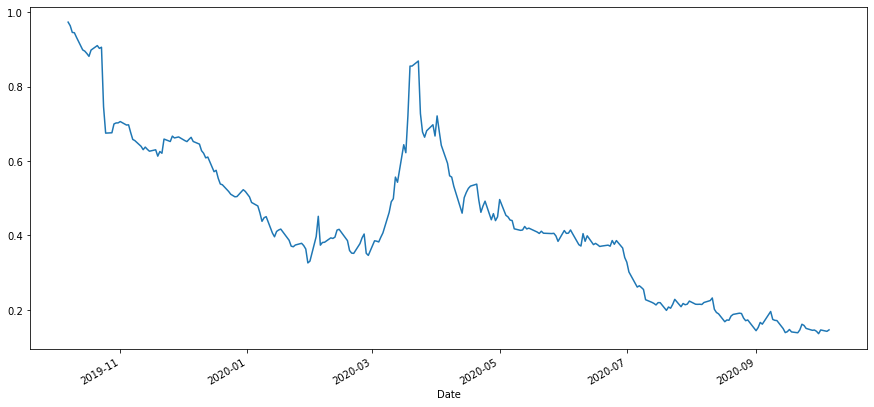

In [35]:
# Calculate cumulative return of model and plot the result of 3 Signals EWM Windows = 50, 200
## removed 'vol_trend_signal' and SENT' and 'bollinger_signal'

(1 + (daily_df['Daily_return'] * daily_df['Predicted_Value'])).cumprod().plot(figsize=(15,7))

<AxesSubplot:xlabel='Date'>

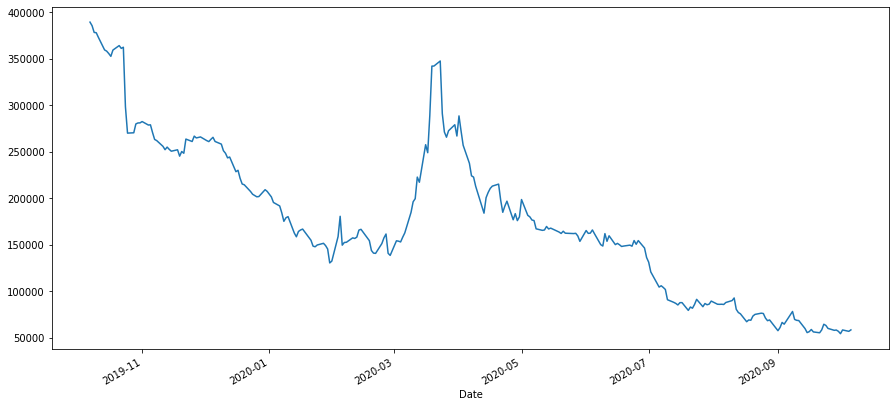

In [36]:
# Set initial capital allocation. (3 Signals EWM Windows = 50, 200)
## 'vol_trend_signal' and SENT' and 'bollinger_signal', 

initial_capital = 400000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (daily_df['Daily_return'] * daily_df['Predicted_Value'])).cumprod()
cumulative_return_capital.plot(figsize=(15,7))


### Plot Entry and Exit Points of Dual Moving Average Crossover Trading Strategy